# *Well-mixed* agent-based simulations w. vaccine hesitancy and assortativity

In [4]:
#For multiple beta values:

import numpy as np
import random
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from numba import njit

@njit
def simulate_one_run(params):
    #beta = params.beta
    #p_a = params.p_a
    beta = params["beta"]
    a = params["a"]       # assortativity in [-1, 1]
    sigma = params["sigma"]
    """
    Run one simulation realization with the given beta.
    Returns:
        peak_infected (int): Maximum number of infected individuals at any time step.
        outbreak (bool): True if peak_infected >= 20, False otherwise.
    """
    # -------------------------
    # Simulation Parameters
    # -------------------------
    N = 2000                   # total population size
    frac_vaccinated = 0.7      # fraction vaccinated
    #a = params["a"]       # assortativity in [-1, 1]
    #sigma = 0.99                # vaccine effectiveness factor (reduces transmission probability)
    gamma = params["gamma"]                # per time-step recovery probability
    contacts_per_infected = 1  # number of contacts per infected agent per time step
    dt = 0.2
    timesteps = int(100/dt)            # total simulation steps

    # -------------------------
    # Initialization
    # -------------------------
    # Determine vaccine status.
    vaccinated = np.random.rand(N) < frac_vaccinated

    # Epidemiological state: 0 = susceptible, 1 = infected, 2 = recovered/protected.
    # Vaccinated individuals start as protected.
    state = np.zeros(N, dtype=np.int64)
    state[vaccinated] = 2

    # Seed the epidemic by infecting one unvaccinated individual.
    unvaccinated_indices = np.where(~vaccinated)[0]
    initial_infected = np.random.choice(unvaccinated_indices)
    state[initial_infected] = 1

    I_history = []

    # -------------------------
    # Simulation Loop
    # -------------------------
    for t in range(timesteps):
        new_state = state.copy()
        infected_indices = np.where(state == 1)[0]

        for i in infected_indices:
            v_status = vaccinated[i]
            # Compute the baseline fraction of individuals with the same vaccine status.
            f_same = np.sum(vaccinated == v_status) / N
            # Compute the probability to contact an individual of the same type.
            if a >= 0:
                p_same = f_same + a * (1 - f_same)
            else:
                p_same = f_same + a * f_same

            for _ in range(contacts_per_infected):
                if random.random() < p_same:
                    # Choose from the same vaccine-status group.
                    candidates = np.where(vaccinated == v_status)[0]
                else:
                    # Choose from the opposite group.
                    candidates = np.where(vaccinated != v_status)[0]
                
                # Avoid self-contact.
                candidates = candidates[candidates != i]
                if len(candidates) == 0:
                    continue
                contact = np.random.choice(candidates)

                # Transmission attempt:
                if state[contact] == 0:
                    # Susceptible (unvaccinated)
                    if random.random() < beta * dt:
                        new_state[contact] = 1
                elif state[contact] == 2:
                    # Recovered/protected; if vaccinated, transmission probability is reduced.
                    # effective_beta = (1.0 - sigma) * beta if vaccinated[contact] else beta
                    effective_beta = (1.0 - sigma) * beta 
                    if random.random() < effective_beta * dt:
                        new_state[contact] = 1

        # Process recoveries.
        for i in infected_indices:
            if random.random() < gamma * dt:
                new_state[i] = 2 if vaccinated[i] else 0

        state = new_state.copy()
        I_history.append(np.sum(state == 1))

    peak_infected = max(I_history)
    outbreak = peak_infected >= 20
    return peak_infected, outbreak

def run_simulations_for_beta(params, num_simulations=200, max_workers=20):
    """
    Runs multiple simulation realizations in parallel for a given beta.
    Returns:
        results (list of tuples): Each tuple is (peak_infected, outbreak).
    """
    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(simulate_one_run, params) for _ in range(num_simulations)]
        for future in as_completed(futures):
            results.append(future.result())
    return results


# Define a structured array type for parameters
param_dtype = np.dtype([
    ('beta', np.float64),
    ('a', np.float64),
    ('sigma', np.float64),
    ('gamma', np.float64),
])

params = np.zeros(1, dtype=param_dtype)[0]


# Define the range of beta values.
betas = np.arange(0, 2.51, 0.1)
outbreak_probabilities_1 = []

asso_1 = 0.99
asso_2 = 0.50
asso_3 = 0.00

params["sigma"] = 0.999
params["gamma"] = 0.2

# Loop over each beta value.
for beta in betas:
    params['beta'] = beta
    params['a'] = asso_1
    results = run_simulations_for_beta(params, num_simulations=300, max_workers=25)
    outbreak_flags = [res[1] for res in results]
    fraction_outbreak = sum(outbreak_flags) / len(outbreak_flags)
    outbreak_probabilities_1.append(fraction_outbreak)
    print(f"Beta = {beta:.2f} -> Outbreak probability: {fraction_outbreak:.3f}")

outbreak_probabilities_2 = []

# Loop over each beta value.
for beta in betas:
    params['beta'] = beta
    params['a'] = asso_2
    results = run_simulations_for_beta(params, num_simulations=300, max_workers=25)
    outbreak_flags = [res[1] for res in results]
    fraction_outbreak = sum(outbreak_flags) / len(outbreak_flags)
    outbreak_probabilities_2.append(fraction_outbreak)
    print(f"Beta = {beta:.2f} -> Outbreak probability: {fraction_outbreak:.3f}")

outbreak_probabilities_3 = []
for beta in betas:
    params['beta'] = beta
    params['a'] = asso_3
    results = run_simulations_for_beta(params, num_simulations=300, max_workers=25)
    outbreak_flags = [res[1] for res in results]
    fraction_outbreak = sum(outbreak_flags) / len(outbreak_flags)
    outbreak_probabilities_3.append(fraction_outbreak)
    print(f"Beta = {beta:.2f} -> Outbreak probability: {fraction_outbreak:.3f}")

Beta = 0.00 -> Outbreak probability: 0.000
Beta = 0.10 -> Outbreak probability: 0.000
Beta = 0.20 -> Outbreak probability: 0.030
Beta = 0.30 -> Outbreak probability: 0.303
Beta = 0.40 -> Outbreak probability: 0.537
Beta = 0.50 -> Outbreak probability: 0.600
Beta = 0.60 -> Outbreak probability: 0.640
Beta = 0.70 -> Outbreak probability: 0.723
Beta = 0.80 -> Outbreak probability: 0.777
Beta = 0.90 -> Outbreak probability: 0.823
Beta = 1.00 -> Outbreak probability: 0.857
Beta = 1.10 -> Outbreak probability: 0.860
Beta = 1.20 -> Outbreak probability: 0.843
Beta = 1.30 -> Outbreak probability: 0.873
Beta = 1.40 -> Outbreak probability: 0.887
Beta = 1.50 -> Outbreak probability: 0.880
Beta = 1.60 -> Outbreak probability: 0.917
Beta = 1.70 -> Outbreak probability: 0.910
Beta = 1.80 -> Outbreak probability: 0.920
Beta = 1.90 -> Outbreak probability: 0.907
Beta = 2.00 -> Outbreak probability: 0.937
Beta = 2.10 -> Outbreak probability: 0.943
Beta = 2.20 -> Outbreak probability: 0.937
Beta = 2.30

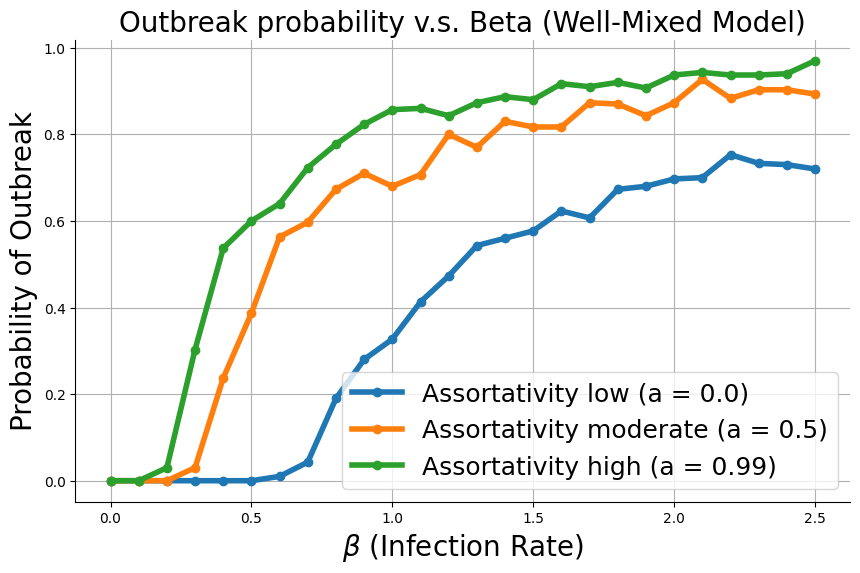

NameError: name 'params' is not defined

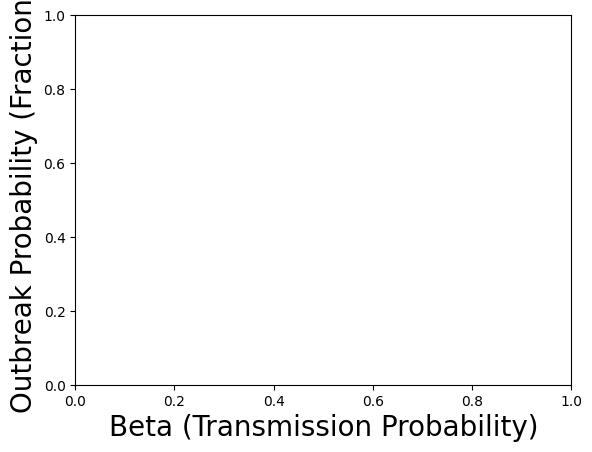

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# -------------------------
# Plotting the Results 1 # recall that the sigma parameter controls the strength of immunity (vaccinated/recovered)
# -------------------------
asso_1 = 0.00
asso_2 = 0.50
asso_3 = 0.99

betas = np.arange(0, 2.51, 0.1)
outbreak_probabilities_3 = [0.000,0.000,0.030,0.303,0.537,0.600,0.640,0.723,0.777,0.823,0.857,0.860,0.843,0.873,0.887,0.880,0.917,0.910,0.920,0.907,0.937,0.943,0.937,0.937,0.940,0.970]
outbreak_probabilities_2 = [0.000,0.000,0.000,0.030,0.237,0.387,0.563,0.597,0.673,0.710,0.680,0.707,0.800,0.770,0.830,0.817,0.817,0.873,0.870,0.843,0.873,0.927,0.883,0.903,0.903,0.893]
outbreak_probabilities_1 = [0.000,0.000,0.000,0.000,0.000,0.000,0.010,0.043,0.190,0.280,0.327,0.413,0.473,0.543,0.560,0.577,0.623,0.607,0.673,0.680,0.697,0.700,0.753,0.733,0.730,0.720]

plt.figure(figsize=(10, 6))
plt.plot(betas, outbreak_probabilities_1, marker='o', linestyle='-', linewidth=4, label=f"Assortativity low (a = {asso_1})")
plt.plot(betas, outbreak_probabilities_2, marker='o', linestyle='-', linewidth=4, label=f"Assortativity moderate (a = {asso_2})")
plt.plot(betas, outbreak_probabilities_3, marker='o', linestyle='-', linewidth=4, label=f"Assortativity high (a = {asso_3})")


plt.xlabel(r"$\beta$ (Infection Rate)", fontsize=20)
plt.ylabel("Probability of Outbreak", fontsize=20)
plt.title("Outbreak probability v.s. Beta (Well-Mixed Model)", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
# plt.ylim([-0.01, 1.02])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

plt.xlabel("Beta (Transmission Probability)", fontsize=20)
plt.ylabel("Outbreak Probability (Fraction)", fontsize=20)
if params["sigma"] > 0.9:
    plt.title("")
else:
    plt.title("Outbreak probability (moderately effective vaccine)")
plt.grid(False)
plt.ylim([-0.01, 1.02])
plt.legend()